# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

import os

In [2]:
cwd = os.getcwd()

PATH_SALES_DF_TRAIN = cwd + '/data/raw/sales_df_train.csv'
PATH_PR_DF = cwd + '/data/raw/pr_df.csv'
PATH_ST_DF = cwd + '/data/raw/st_df.csv'
PATH_SALES_SUBMITIONS = cwd + '/data/raw/sales_submission.csv'

Для анализа и дальнейшего обучения модели предоставлены следующие датасеты:

**sales_df_train.csv** –данные по продажам за скользящий год для обучения.  
Столбцы: 
st_id – захэшированное id магазина;  
pr_sku_id – захэшированное id товара;  
date – дата;  
pr_sales_type_id – флаг наличия промо;  
pr_sales_in_units – число проданных товаров без признака промо;  
pr_promo_sales_in_units – число проданных товаров с признаком промо;  
pr_sales_in_rub – продажи без признака промо в РУБ;  
pr_promo_sales_in_rub – продажи с признаком промо в РУБ;  

**pr_df.csv** – данные по товарной иерархии. 
Столбцы:  
pr_group_id – захэшированная группа товара; 
pr_cat_id – захэшированная категория товара; 
pr_subcat_id – захэшированная подкатегория товара;
pr_sku_id – захэшированное id товара;
pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).

**pr_st.csv** – данные по магазинам. 
Столбцы: 
st_id – захэшированное id магазина;  
st_city_id – захэшированное id города;  
st_division_code id – захэшированное id дивизиона;  
st_type_format_id – id формата магазина;  
st_type_loc_id – id тип локации/окружения магазина; 
st_type_size_id – id типа размера магазина;  
st_is_active – флаг активного магазина на данный момент.  

Прогноз необходимо предоставить в следующем формате:

**sales_submission.csv** – пример файла с результатом работы модели прогноза спроса. 
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по 
умолчанию колонка заполнена нулями). 
Столбцы: 
st_id – захэшированное id магазина; 
pr_sku_id – захэшированное id товара;  
date – дата (день);  
target – спрос в ШТ

Начнём изучение данных с датасета sales_df_train

In [3]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
sales_df_train.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [4]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [5]:
sales_df_train.describe()

,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
count,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,0.406486,5.037956,2.230010,596.705181,294.766561
std,0.491178,13.402984,11.063288,1577.366179,1402.764168
min,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000
25%,0.000000,1.000000,0.000000,98.000000,0.000000
50%,0.000000,2.000000,0.000000,224.000000,0.000000
75%,1.000000,4.000000,1.000000,540.000000,127.000000
max,1.000000,2348.000000,2348.000000,183265.000000,183265.000000


В данных нет пропусков, однако столбец с датой необходимо привести к  формату datetime и упорядочить по данному столбцу, поскольку сейчас данные записаны в разнобой, в столбцах pr_sales_in_units, pr_promo_sales_in_units, pr_sales_in_rub, pr_promo_sales_in_rub есть отрицательные значения, вероятнее всего это возвраты товаров.

In [6]:
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'])

In [7]:
sales_df_train = sales_df_train.sort_values(by=['date', 'st_id', 'pr_sku_id'])

Посмотрим максимальную и минимальную дату в датасете

In [8]:
sales_df_train['date'].min(), sales_df_train['date'].max()

(Timestamp('2022-08-01 00:00:00'), Timestamp('2023-07-18 00:00:00'))

В наличии есть данные чуть больше чем за год. К сожалению это не позволит нам проанализировать и использовать годовые патерны (не получиться учесть годовую сезонность).

## Анализ общего числа продаж

Проанализируем изменение общего числа продаж всех товаров, для этого сгруппируем данные по дате и агрегируем по сумме число проданных товаров по промо и без промо.

In [9]:
df_ts = sales_df_train.groupby('date')[['pr_sales_in_units','pr_promo_sales_in_units']].agg('sum').resample("1D").sum()

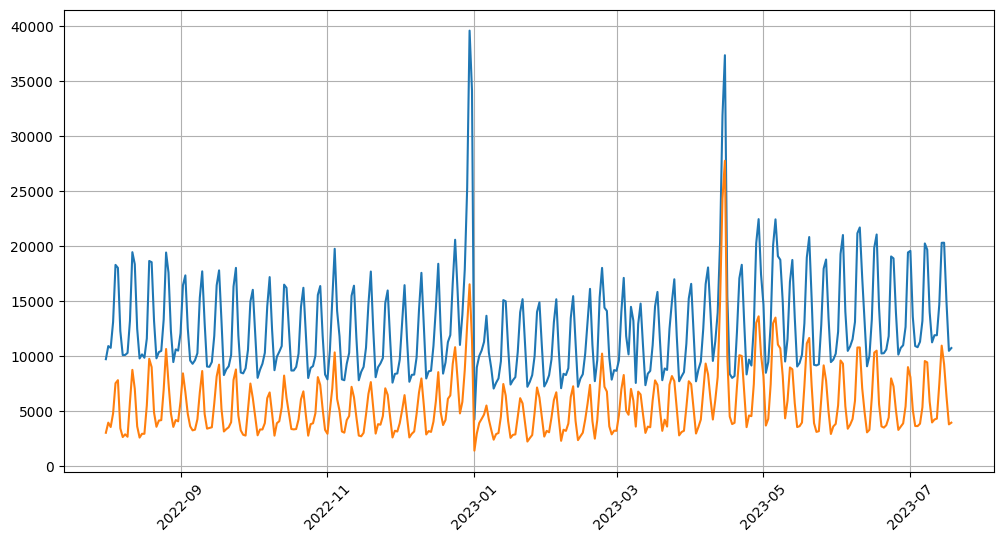

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df_ts)
plt.grid()
plt.xticks(rotation=45)
plt.show()

В графиках явно просматривается сезонность причём она характерна как для обычных товаров, так и для акционных. Кроме того на выходные и праздничные дни присутсвуют пики в праздничные дни. Так же есть два максимальных пика один 31 декабря (вероятно, связаный с новым годом), второй в середине апреля, попорбуем определить на какую дату он попал.

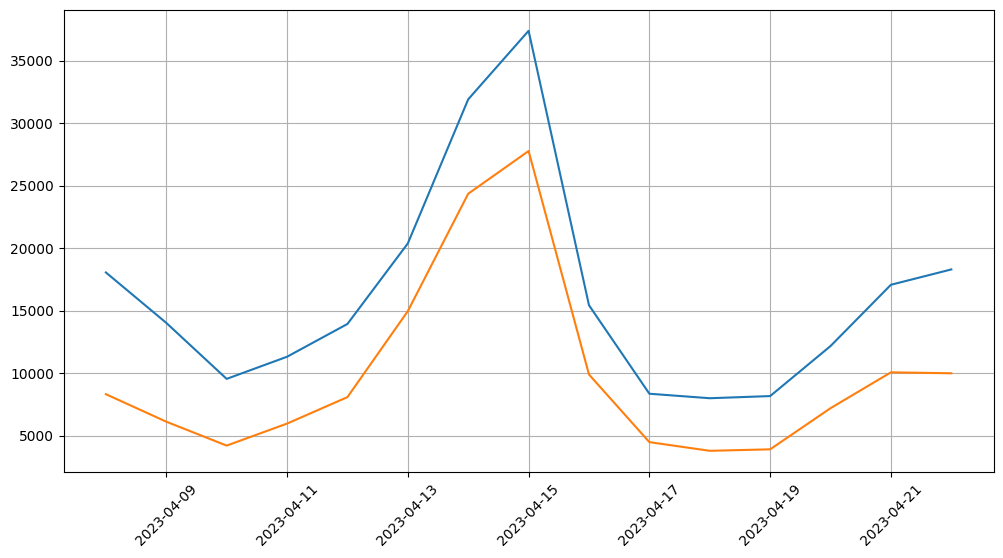

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df_ts['2023-04-08':'2023-04-22'])
plt.grid()
plt.xticks(rotation=45)
plt.show()

Данный праздник выпадает на 15 апреля. Первоначально было предположение, что это связано с погодой, но 15 и 16 апреля в 2023 году не отличалось особо хорошей погодой, однако 16 апреля была православная пасха, можно выдвинуть гипотезу, что именно это и является причиной, но чтобы это проверить, требуется срез за более ранний период (желательно за несколько лет). Поскольку Новый год и пасха даёт прирост примерно одного порядка, то для них лучше сделать отдельный признак.

Также после нового года наблюдается спад продаж

Проанализируем наличие отрицательных значений в датасете, посчитаем количество таких строк

In [12]:
sales_df_train[(sales_df_train['pr_sales_in_units']<0) |
               (sales_df_train['pr_promo_sales_in_units']<0) |
               (sales_df_train['pr_sales_in_rub']<0) |
               (sales_df_train['pr_promo_sales_in_rub']<0)]['pr_sku_id'].count()

79

Всего таких строк 79, вероятнее всего это действительно возвраты. Учитывая что общее количество строк в датасете 883015, то удалим эти строки на предобработке

Посмотрим как часто встречаются строки с 0 в pr_sales_in_units и pr_promo_sales_in_units (т.е. продажи с 0 количеством)

In [13]:
sales_df_train[(sales_df_train['pr_sales_in_units']==0) &
               (sales_df_train['pr_promo_sales_in_units']==0)]['pr_sku_id'].count()

66543

In [14]:
sales_df_train[(sales_df_train['pr_sales_in_units']==0) &
               (sales_df_train['pr_promo_sales_in_units']==0)]['pr_sku_id'].count() / len(sales_df_train)

0.0753588557385775

Таких строк 7,5% от общего количества строк, это достаточно большой объём данных, нужно будет разобраться в причинах таких нулей. 

Посмотрим на сезонность в данных

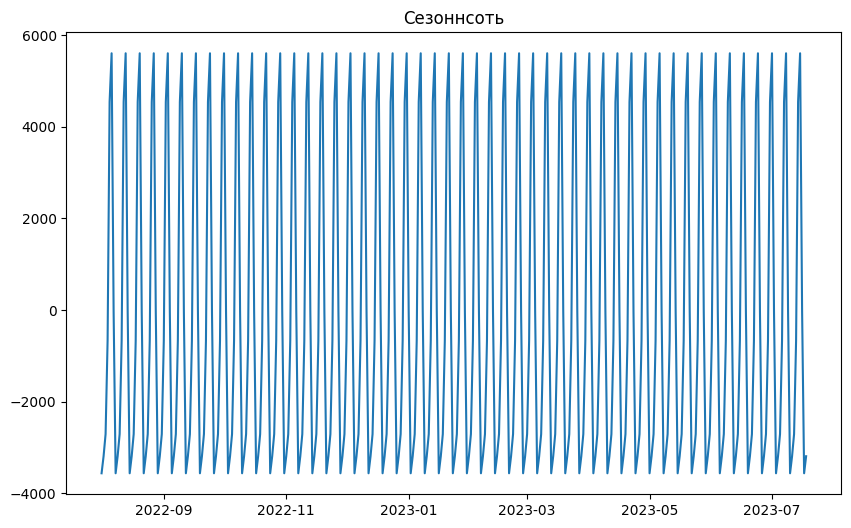

In [15]:
decomposed = seasonal_decompose(df_ts['pr_sales_in_units'])
plt.figure(figsize=(10,6))
plt.plot(decomposed.seasonal)
plt.title('Сезоннсоть')
plt.show()

Как и предполагалось в данных есть сезонность, сденлаем срез, чтобы увеличить данные и лучше её рассмотреть.

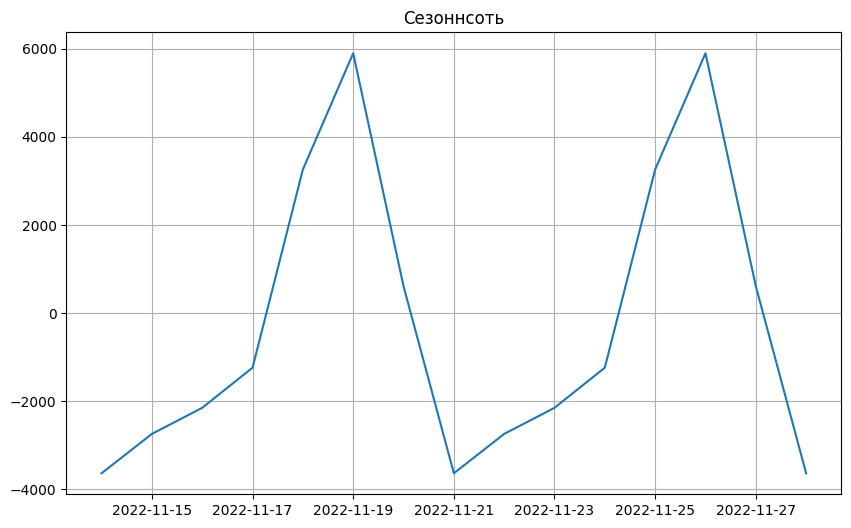

In [16]:
decomposed = seasonal_decompose(df_ts['2022-11-14':'2022-11-28']['pr_sales_in_units'])
plt.figure(figsize=(10,6))
plt.plot(decomposed.seasonal)
plt.title('Сезоннсоть')
plt.grid()
plt.show()

Сезонность по продажам составляет примерно неделю. Поэтому в качестве признака разумно использовать лаг в 7 дней.

Посмотрим на какой день недели приходится пик. Ниже приведены номера дней недели с пиками на основании срезов (вывод графиков удалён, чтобы не загромождать тетрадку)

In [17]:
datetime.strptime('2023-11-19', '%Y-%m-%d').weekday()

6

In [18]:
datetime.strptime('2023-05-27', '%Y-%m-%d').weekday()

5

In [19]:
datetime.strptime('2023-01-21', '%Y-%m-%d').weekday()

5

In [20]:
datetime.strptime('2023-10-15', '%Y-%m-%d').weekday()

6

Пики продаж приходятся чаще всего на конец недели (видимо сказываются выходные дни), а минимумы продаж на начало рабочей недели.

In [21]:
del df_ts, decomposed

## Анализ магазинов

Для начала проанализируем данные из датасета sales_df_train, посмотрим сколько магазинов встречается в датасете и как часто они попадаются

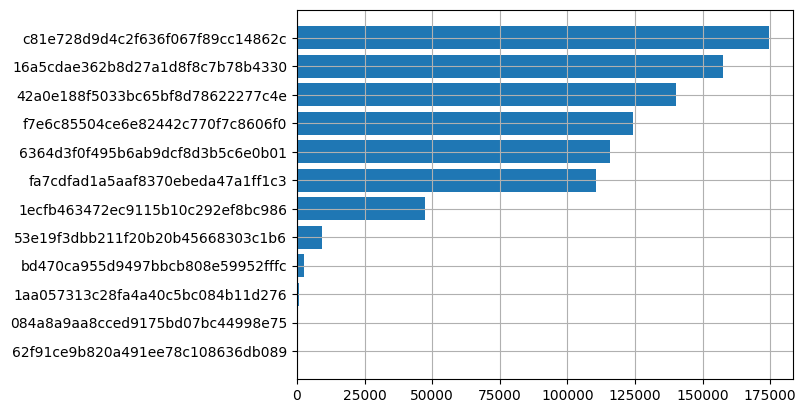

In [22]:
df_st_id = (sales_df_train.groupby('st_id')['pr_sales_in_units'].agg('count')
                  .reset_index(drop=False)
                  .sort_values(by='pr_sales_in_units'))

plt.barh(df_st_id['st_id'], df_st_id['pr_sales_in_units'])
plt.grid()
plt.show()

Как видим магазинов всего 12 штук при этом можно выделить несколько групп. При этом наблюдается разброс по количеству вхождений. Это может быть связано как с тем, что какие-то магазины пополярнее других, так и с тем, что есть новые магазины и общее значение вхождений у них значително меньше. Поэтому разумнее оперировать средним колдичеством проданных товаров. Сделаем такое преобразование.

In [23]:
df_st_id = (sales_df_train.groupby('st_id')[['pr_sales_in_units', 'pr_promo_sales_in_units']].agg('mean')
                  .reset_index(drop=False)
                  .sort_values(by='pr_sales_in_units'))

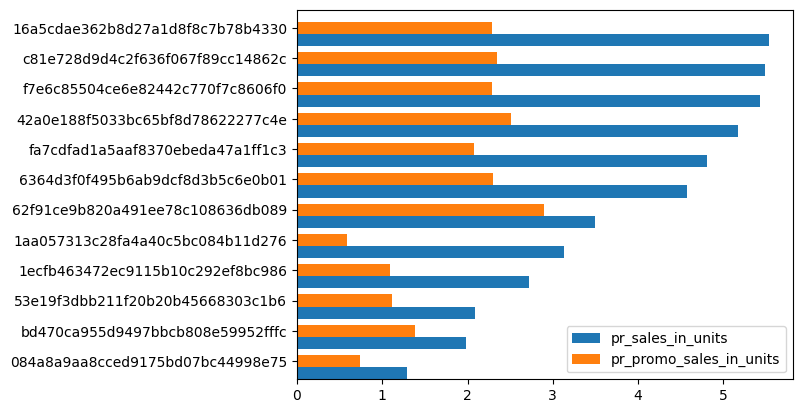

In [24]:
ind = np.arange(len(df_st_id))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df_st_id['pr_sales_in_units'], width, label='pr_sales_in_units')
ax.barh(ind + width, df_st_id['pr_promo_sales_in_units'], width, label='pr_promo_sales_in_units')

ax.set(yticks=ind + width, yticklabels=df_st_id['st_id'], ylim=[2*width - 1, len(df_st_id)])
ax.legend()
plt.show()

На основании полученной диаграммы можно выделить следующие группы магазинов по среднему количеству проданных товаров:
* Магазины со средним значением меньше 2,5
* Магазины со средним значением от 2,5 до 4
* Магазины со средним значением от 4 до 5
* Магазины со средним значением свыше 5

Однако выбросы в течении года могут сильно повлиять на данный показатель, поэтому построим графики со скользящим средним (периодом в месяц).

In [25]:
df_st_id = sales_df_train.groupby(['date','st_id'])[['pr_sales_in_units','pr_promo_sales_in_units']].agg('sum').reset_index(drop=False)

In [26]:
df_st_id.index = df_st_id['date']
df_st_id = df_st_id.drop('date', axis=1)

In [27]:
def det_rolling_mean(df, group_column, cloumn):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name = f'rolling_mean_{cloumn}'
        df_st_id.loc[df_st_id[group_column]==gr_col, new_name] = (df_st_id[df_st_id[group_column]==gr_col][cloumn]
                                                                    .shift()
                                                                    .rolling(30)
                                                                    .mean())
    df = df.drop(cloumn, axis=1)
    return df

In [28]:
df_st_id = det_rolling_mean(df_st_id, 'st_id', 'pr_sales_in_units')
df_st_id = det_rolling_mean(df_st_id, 'st_id', 'pr_promo_sales_in_units')

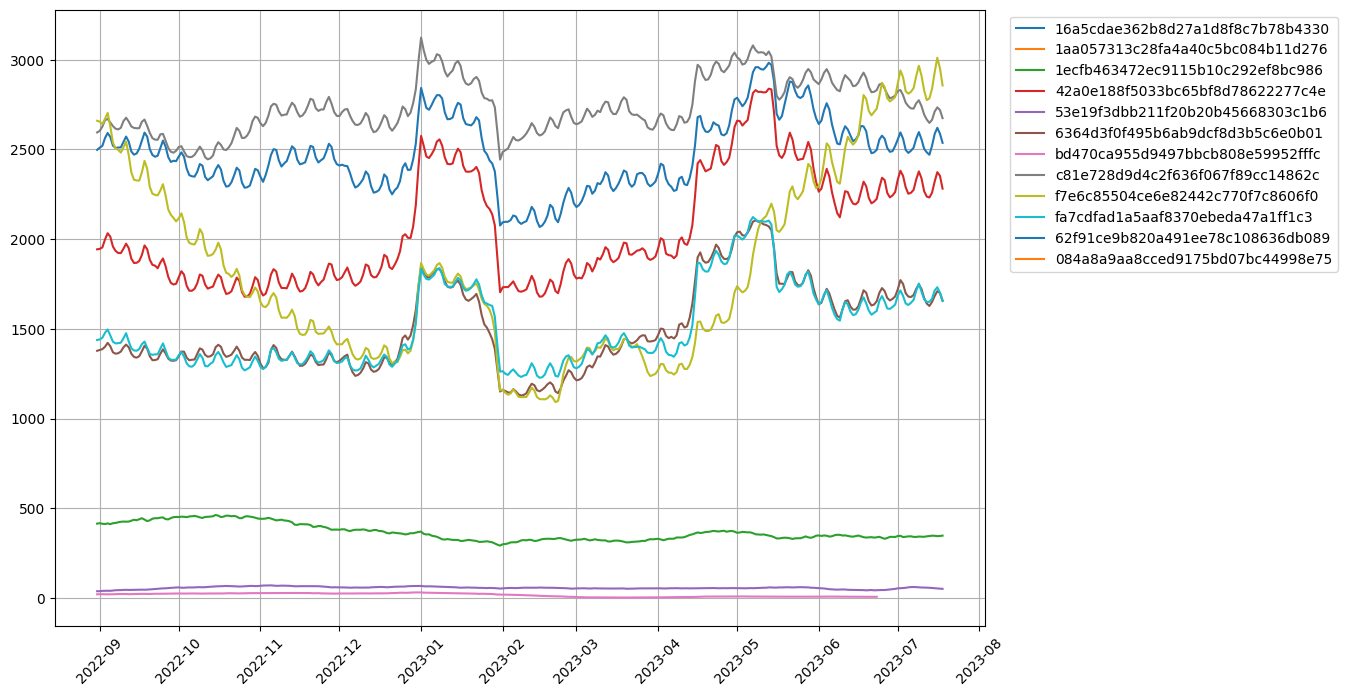

In [29]:
plt.figure(figsize=(12,8))
for gr_col in df_st_id['st_id'].unique():
    plt.plot(df_st_id.loc[df_st_id['st_id'] == gr_col, 'rolling_mean_pr_sales_in_units'], label=gr_col)
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left')
plt.grid()
plt.xticks(rotation=45)
plt.show()

По графику видно, что хорошо выделяется группа магазинов со месячным скользящим среднем меньше 500 (у них координально отличается поведение). У остальных магазинов, кроме жёлтого идёт схожее изменение продаж, отличается только количество.
Поведение магазино с жёлтым графиком весьма странное он перестраивается из топовых магазинов в среднии, затем возвращается обратно. При этом это может быть связано как с обратной сезонностью (например это единственный магазин в южной части страны и у него обратная сезонность), либо это связано с неизвестным фактором, но для этого нужен срез за больший период. Однако пока примем решение делать для него отдельную модель.

Возможно стоит выделить в отдельную модель магазины среднего уровня, со скользящим среднимбольше 500 до 1800

Расмотрим как меняется доля скользящего среднего по товарам по акции и без акции

In [30]:
df_st_id['sale_ratio_rm_promo_to_non_promo'] = df_st_id['rolling_mean_pr_promo_sales_in_units'] / df_st_id['rolling_mean_pr_sales_in_units']

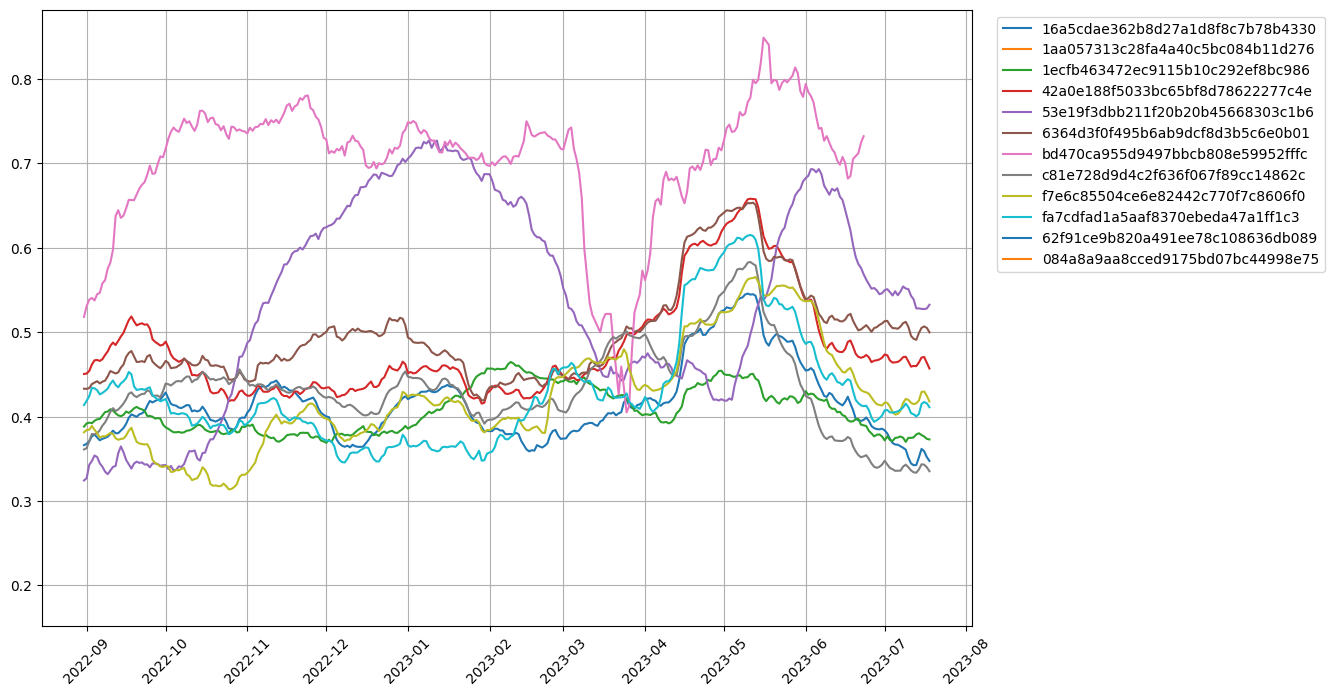

In [31]:
plt.figure(figsize=(12,8))
for gr_col in df_st_id['st_id'].unique():
    plt.plot(df_st_id.loc[df_st_id['st_id'] == gr_col, 'sale_ratio_rm_promo_to_non_promo'], label=gr_col)
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left')
plt.grid()
plt.xticks(rotation=45)
plt.show()

По отношению количества проданных товаров по акции к количество товаров проданных без акции также выбиваются два магазина (они же имели и меньшее из скользящих средних. Также отличатеся динамика промоакций для зелёного магазина.

Для более глубокого анализа присоединим оставшиеся датасеты

In [39]:
def get_last_data(path_to_train: str) -> datetime:
    """Функция для получения последней даты в обучающей выборке
    :param path_to_train: Путь до тренировочного датасета
    :return:
    """
    with open(path_to_train) as file:
        last_date = file.read()
    return datetime.strptime(last_date, '%Y-%m-%d')

In [40]:
def get_predict(st_id: str, sku_id: str):
    """Функция для получения предсказания спроса
    :param st_id: id магазина
    :param sku_id: id товара
    :return: Возвращает json с датами и спросом для соответствующего товара и магазина
    """
    last_day = get_last_data(PATH_TO_LAST_DAY)
    list_date = [last_day + timedelta(days=x) for x in range(14)]
    list_sales_in_units = np.random.randint(0, 20, 14)
    df = pd.DataFrame({ 'date': list_date,
                        'sales_in_units': list_sales_in_units})
    df['date'] = df['date'].astype('str')
    return df.to_json(orient="records")

In [41]:
PATH_TO_LAST_DAY= cwd + '/last_date.txt'
get_predict('aaa', 'bbb')

'[{"date":"2023-07-18","sales_in_units":1},{"date":"2023-07-19","sales_in_units":5},{"date":"2023-07-20","sales_in_units":19},{"date":"2023-07-21","sales_in_units":15},{"date":"2023-07-22","sales_in_units":14},{"date":"2023-07-23","sales_in_units":7},{"date":"2023-07-24","sales_in_units":18},{"date":"2023-07-25","sales_in_units":6},{"date":"2023-07-26","sales_in_units":9},{"date":"2023-07-27","sales_in_units":15},{"date":"2023-07-28","sales_in_units":3},{"date":"2023-07-29","sales_in_units":16},{"date":"2023-07-30","sales_in_units":5},{"date":"2023-07-31","sales_in_units":6}]'